## **Note**
##### This material is mainly aiming to crystallize my knowledge. Any suggestion or correction would be gladly accepted
<br>
This notebook uses a multi-heads simple CNN for a multiclass classification task on a dynamically created dataset. The model is built using the Keras functional API.
<br><br>

#### A non-exhaustive list of benefits brought by multi-heads (or multi-outputs) neural networks:
* "The NN may learn hidden representations which are useful for predicting all of the outputs of the NN" https://goo.gl/xQQJ74 
* If an NN's outputs are using common patterns for prediction, shared representations is a way to lower the cost of computation (useful for speeding up inference time and real-time predictions)
* ...

<br>
The notebook's implementation might not be the best example to emphasize those benefits as it is being used to detect colors and shapes. The two categories do not share common patterns so it might be worth to use a smaller and more optimized network for each task. However, it remained a good example to understand the concept and how to build such a model.

<br>
If you want to get more insights I suggest you read the following post:https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/ 

In [1]:
import cv2
import numpy as np

import keras.layers as KL
import keras.callbacks as KC
import keras.utils as KU
from keras.models import Model
from keras.optimizers import Adam
from keras import metrics

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\vincent.local\Anaconda3\envs\py\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [2]:
class Config():
    """Configuration 
    """
    IMG_SIZE = 128
    
    EPOCHS = 50
    
    COLORS = ['red', 'green', 'blue']
    
    SHAPES = ['circle', 'rectangle']
    
config = Config()

## **Dataset**
<br>
For convenience, an artificial dataset is created by drawing random shapes and colors using OpenCV. Doing so, we can extend the dataset as necessary. Once the model will be trained, we can also easily make new samples to see how well our network is able to generalize.

In [3]:
def random_shape(img, r_shapes,r_colors,colors, i):
    '''Draw a rectangle or a circle with random coordinates
    and a random color
    '''
    if(r_shapes[i] == 0):
        coord = np.random.randint(config.IMG_SIZE, size=(1, 2))
        size = np.random.randint(40, size=1)
        
        cv2.circle(img,(
            coord[0][0],coord[0][1]), 
                   size[0] +10, 
                   colors[r_colors[i]], -1)
        
    elif(r_shapes[i] == 1):
        center = np.random.randint(config.IMG_SIZE//2, size=2)+30
        coord = np.random.randint(config.IMG_SIZE//3, size=4)
        
        cv2.rectangle(img,
                      (center[0] - coord[0],center[1] - coord[1]),
                      (center[0] + coord[2],center[1] + coord[3]),
                      colors[r_colors[i]], 
                      thickness  = 3)

        
def create_data(nbr = 60):
    '''Build toy dataset
    '''
    r_shapes = np.random.randint(2, size=nbr) 
    r_colors = np.random.randint(3, size=nbr) 
    colors = [(255,0,0),(0,255,0),(0,0,255)]
    data = np.empty((0,config.IMG_SIZE,config.IMG_SIZE,3))
    
    for i in range(nbr):
        img = np.zeros((config.IMG_SIZE,config.IMG_SIZE,3), np.uint8)
        random_shape(img, r_shapes,r_colors, colors, i)
        img = np.expand_dims(img, 0)
        data = np.append(data, img, axis=0)
    
    return data, r_shapes, r_colors

data, r_shapes, r_colors =  create_data(2500)

In [4]:
def create_categorical_truth(r_shapes, r_colors):
    '''
    Create categorical truths for shapes and colors
    '''
    y_shape = KU.to_categorical(list(r_shapes))
    y_color = KU.to_categorical(list(r_colors))

    return y_shape, y_color

y_shape, y_color = create_categorical_truth(r_shapes, r_colors)

In [5]:
#Sanity check
data.shape, y_shape.shape, y_shape.shape

((2500, 128, 128, 3), (2500, 2), (2500, 2))

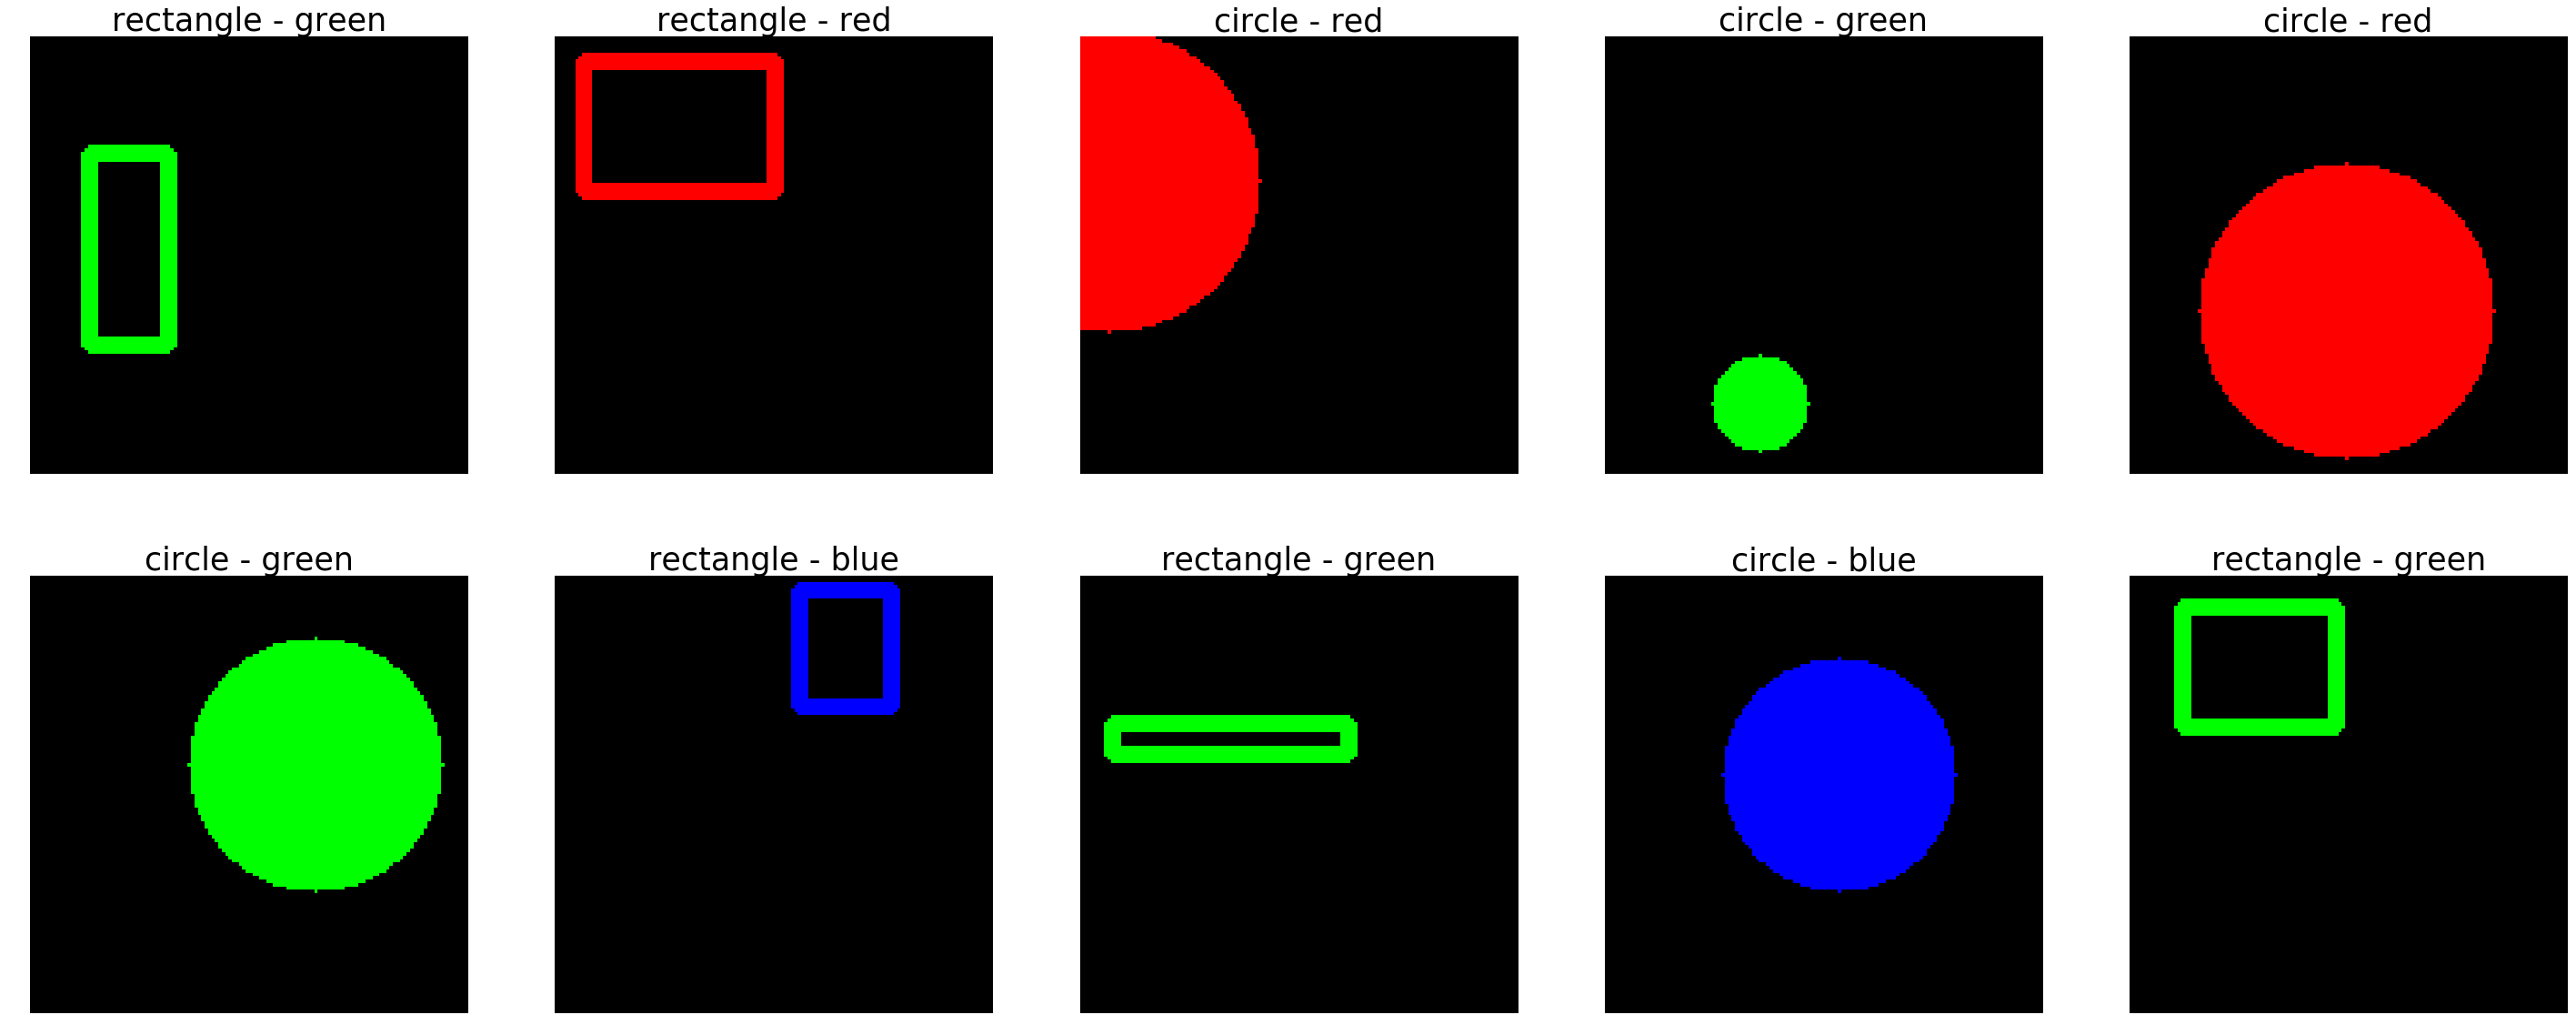

In [6]:
def display_random_data(data, r_shapes, r_colors, rows):
    '''Display randomly selected samples from the toy dataset
    '''
    idx = np.random.randint(data.shape[0], size=rows*4)
    fig, axarr = plt.subplots(2, rows, figsize=(rows*10, rows*4))

    for i in range(1,rows*2+1):
        
        sample = idx[i]
        img = data[sample]/255
        title = config.SHAPES[r_shapes[sample]] +' - '+ config.COLORS[r_colors[sample]]
        
        axarr[i//(rows+1),i%rows].imshow(img)
        axarr[i//(rows+1),i%rows].set_title(title, fontsize=35)
        axarr[i//(rows+1),i%rows].axis('off')
        
display_random_data(data, r_shapes, r_colors, 5)

In [7]:
def build_head(x, label_nbr, last_layer_name):
    '''Build the head for each output
    '''
    x = KL.Flatten()(x)
    x = KL.Dense(64, activation='relu')(x)
    x = KL.Dense(label_nbr)(x)
    x = KL.Activation('softmax', name=last_layer_name)(x)
    return x;


def build_model(num_shape, num_color):
    '''Build model
    '''
    inputs = KL.Input(shape=(config.IMG_SIZE, config.IMG_SIZE, 3))
    x = KL.ZeroPadding2D((3, 3))(inputs)
    x = KL.Conv2D(32, (3, 3), strides = (1, 1))(inputs)
    x = KL.BatchNormalization(axis = 3)(x)
    x = KL.Activation('relu')(x)
    x = KL.MaxPooling2D((2, 2))(x)
    x = KL.Dropout(0.25)(x)

    shapeBranch = build_head(x, num_shape, 'shape')
    colorBranch = build_head(x, num_color, 'color')

    return Model(
        inputs=inputs,
        outputs= [shapeBranch, colorBranch],
        name="shape_color_cls")


def prepare_model(model):
    '''Compile model
    '''
    losses = {
        "shape": "categorical_crossentropy",
        "color": "categorical_crossentropy",
        }

    lossWeights = {"shape": 1.0, "color": 1.0}


    model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
                      loss=losses,
                      loss_weights=lossWeights,
                      metrics=[metrics.categorical_accuracy])

    
def train_model(model, data, y_shape, y_color):
    '''
    Train model
    Compile the model

    Return:
    H -- history of training
    '''
    H = model.fit(
        data,
        {"shape": y_shape, "color": y_color},
        epochs=config.EPOCHS,
        batch_size=16)

    return H

In [8]:
model = build_model(y_shape.shape[1], y_color.shape[1])
prepare_model(model)
H = train_model(model, data, y_shape, y_color)

Epoch 1/100
2500/2500 [==============================] - 7s 3ms/step - loss: 0.6102 - shape_loss: 0.4701 - color_loss: 0.1401 - shape_categorical_accuracy: 0.8224 - color_categorical_accuracy: 0.9456
Epoch 2/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1565 - shape_loss: 0.1331 - color_loss: 0.0233 - shape_categorical_accuracy: 0.9492 - color_categorical_accuracy: 0.9916
Epoch 3/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.0754 - shape_loss: 0.0724 - color_loss: 0.0029 - shape_categorical_accuracy: 0.9780 - color_categorical_accuracy: 0.9992
Epoch 4/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.0306 - shape_loss: 0.0296 - color_loss: 9.1947e-04 - shape_categorical_accuracy: 0.9900 - color_categorical_accuracy: 1.0000
Epoch 5/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.0135 - shape_loss: 0.0131 - color_loss: 4.0559e-04 - shape_categorical_accuracy: 0.9976 - color_categorical_accuracy:

2500/2500 [==============================] - 4s 2ms/step - loss: 0.0126 - shape_loss: 0.0103 - color_loss: 0.0023 - shape_categorical_accuracy: 0.9968 - color_categorical_accuracy: 0.9996
Epoch 77/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.0036 - shape_loss: 8.8969e-04 - color_loss: 0.0027 - shape_categorical_accuracy: 0.9996 - color_categorical_accuracy: 0.9996
Epoch 78/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.0031 - shape_loss: 0.0027 - color_loss: 3.7096e-04 - shape_categorical_accuracy: 0.9996 - color_categorical_accuracy: 1.0000    
Epoch 79/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.0105 - shape_loss: 0.0101 - color_loss: 3.9300e-04 - shape_categorical_accuracy: 0.9980 - color_categorical_accuracy: 0.9996
Epoch 80/100
2500/2500 [==============================] - 4s 2ms/step - loss: 0.0035 - shape_loss: 1.2816e-04 - color_loss: 0.0034 - shape_categorical_accuracy: 1.0000 - color_categorical_accur

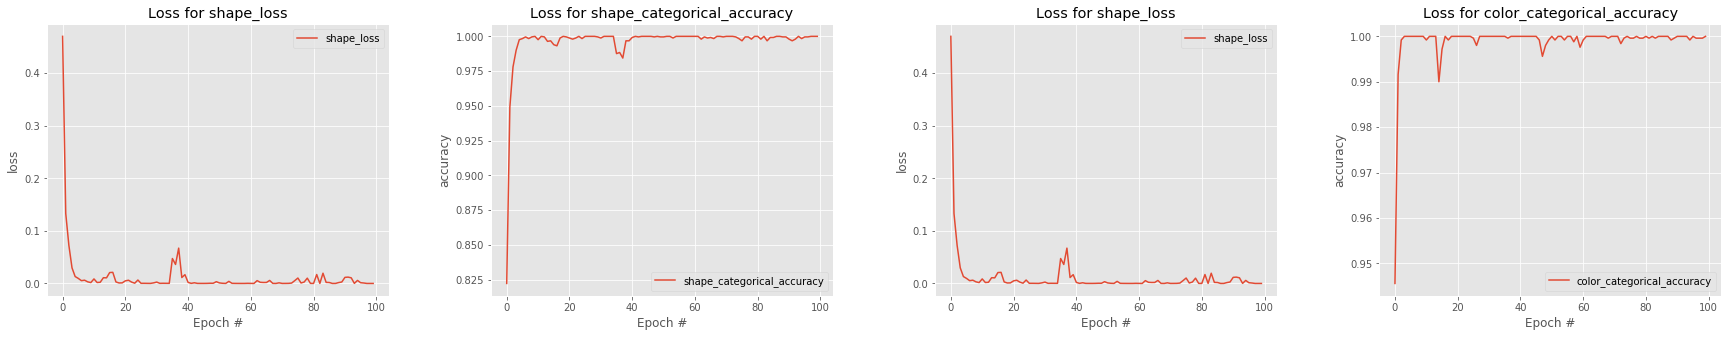

In [9]:
def analyse_results(epochs, history):
    '''plot metrics to analyse the learning evolution
    '''
    metrics = [
        'shape_loss',
        "shape_categorical_accuracy",
        'shape_loss',
        'color_categorical_accuracy']
    
    plt.style.use("ggplot")
    (fig, ax) = plt.subplots(1, 4, figsize=(30, 5))
    fig.subplots_adjust(hspace=0.1, wspace=0.3)

    for (i, l) in enumerate(metrics):
        title = "Loss for {}".format(l) if l != "loss" else "Total loss"
        ax[i].set_title(title)
        ax[i].set_xlabel("Epoch #")
        ax[i].set_ylabel(l.split('_')[-1])
        ax[i].plot(np.arange(0, epochs), history.history[l], label=l)
        ax[i].legend()
        
analyse_results(config.EPOCHS, H)

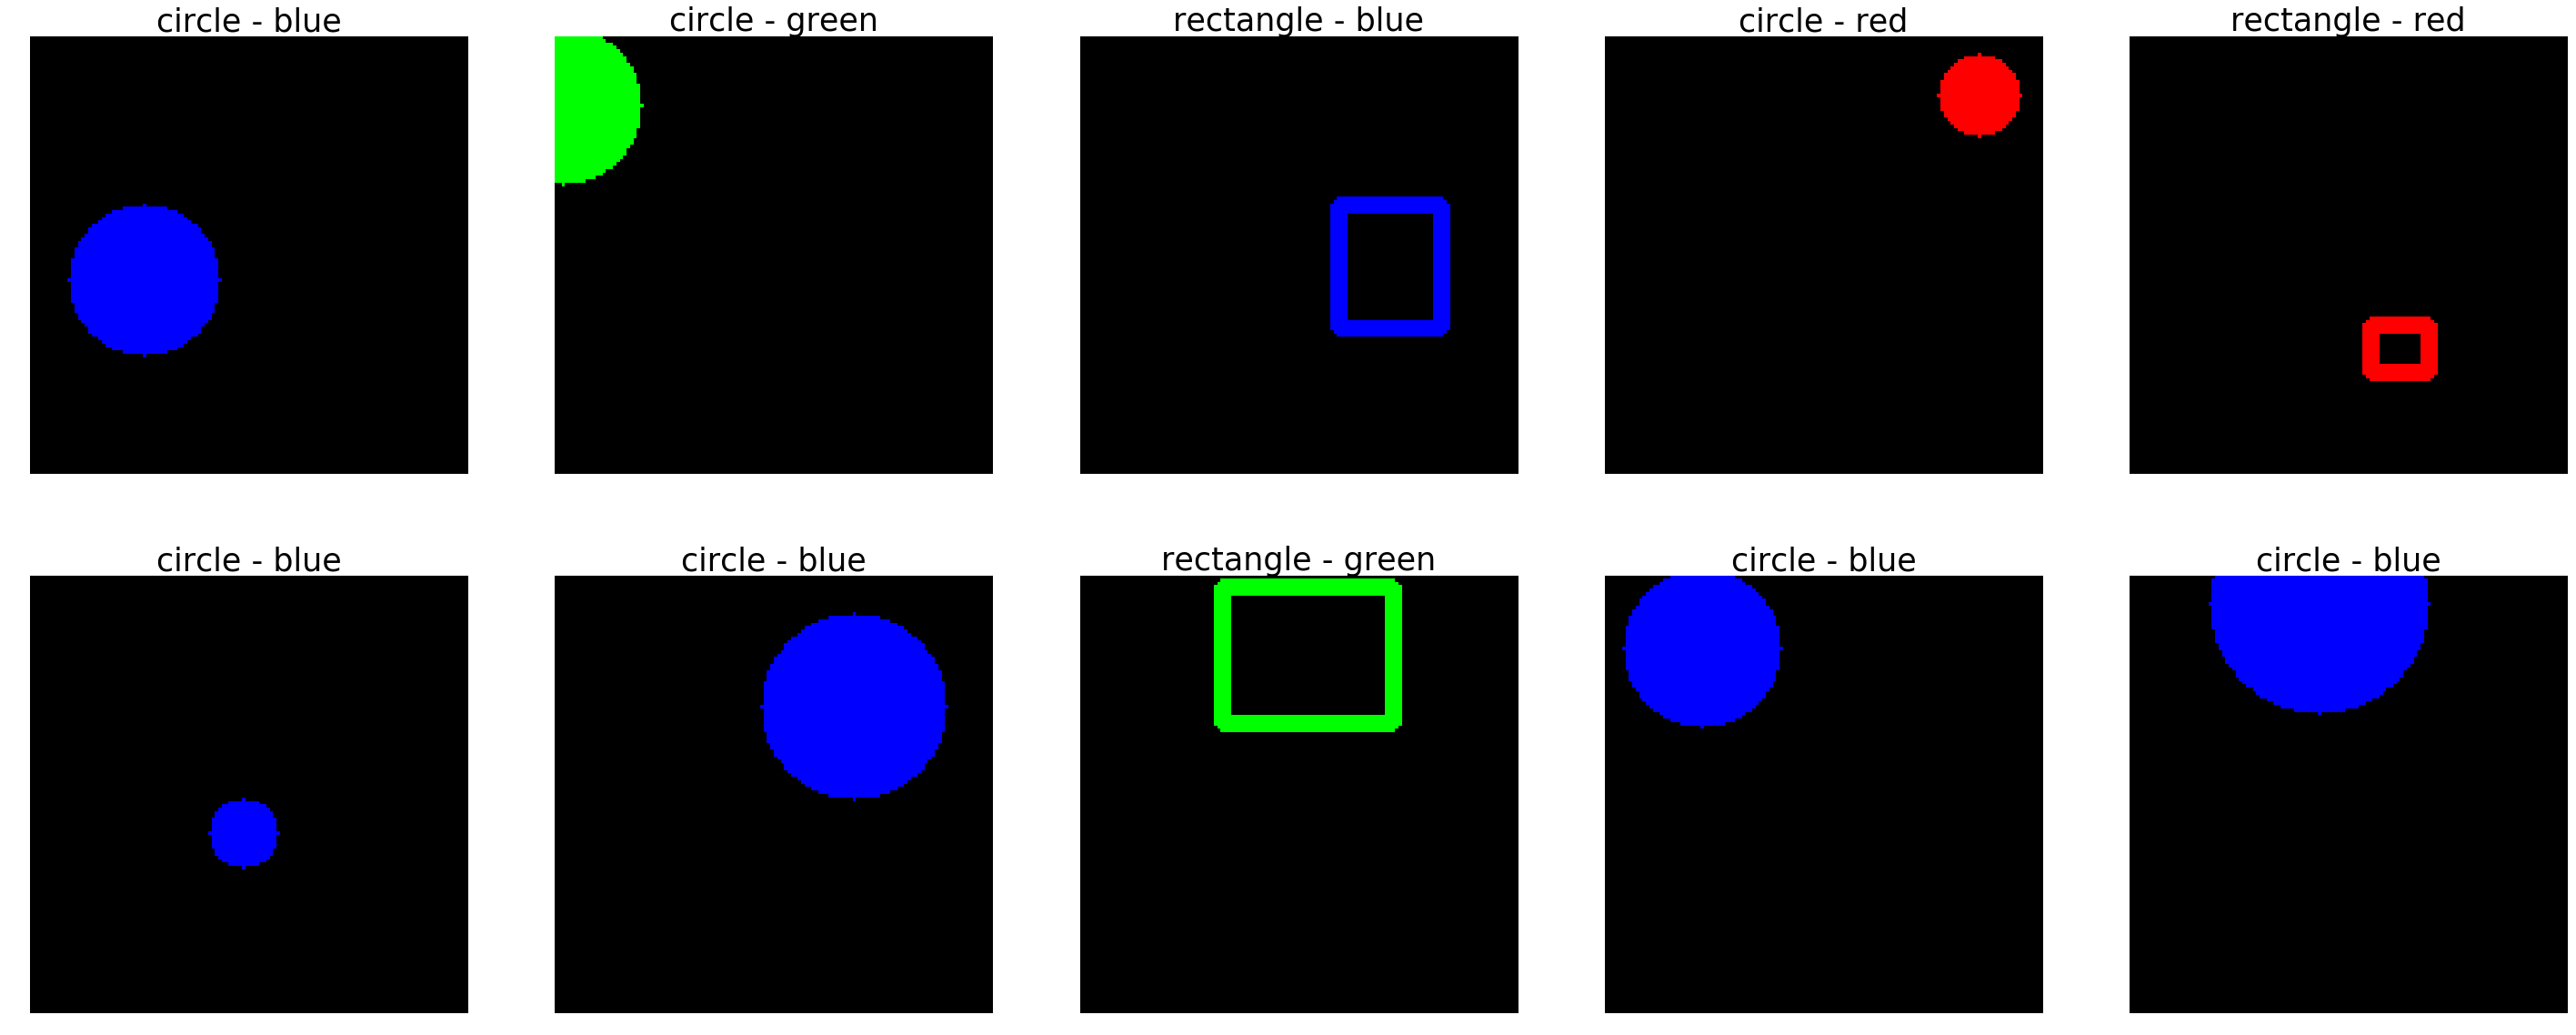

In [10]:
def display_random_data(model, data, rows):
    '''Predict samples from training data 
    to see if the network was able to classify them accurately
    '''
    idx = np.random.randint(data.shape[0], size=rows*4)
    fig, axarr = plt.subplots(2, rows, figsize=(rows*10, rows*4))
    
    for i in range(1,rows*2+1):
        img = data[idx[i]]
        to_pred = np.expand_dims(img, axis=0)
        pred = model.predict(to_pred, True)
        
        title = config.SHAPES[np.argmax(pred[0])] +' - '+ config.COLORS[np.argmax(pred[1])]
        
        img = data[idx[i]]/255
        axarr[i//(rows+1),i%rows].imshow(img)
        axarr[i//(rows+1),i%rows].set_title(title, fontsize=35)
        axarr[i//(rows+1),i%rows].axis('off')
        
display_random_data(model,data, 5)

## **Generalization**
<br>
As said previously, artificial datasets allow us to create new data easily. We can then use our network to make predictions on those new samples and see how well it generalizes.

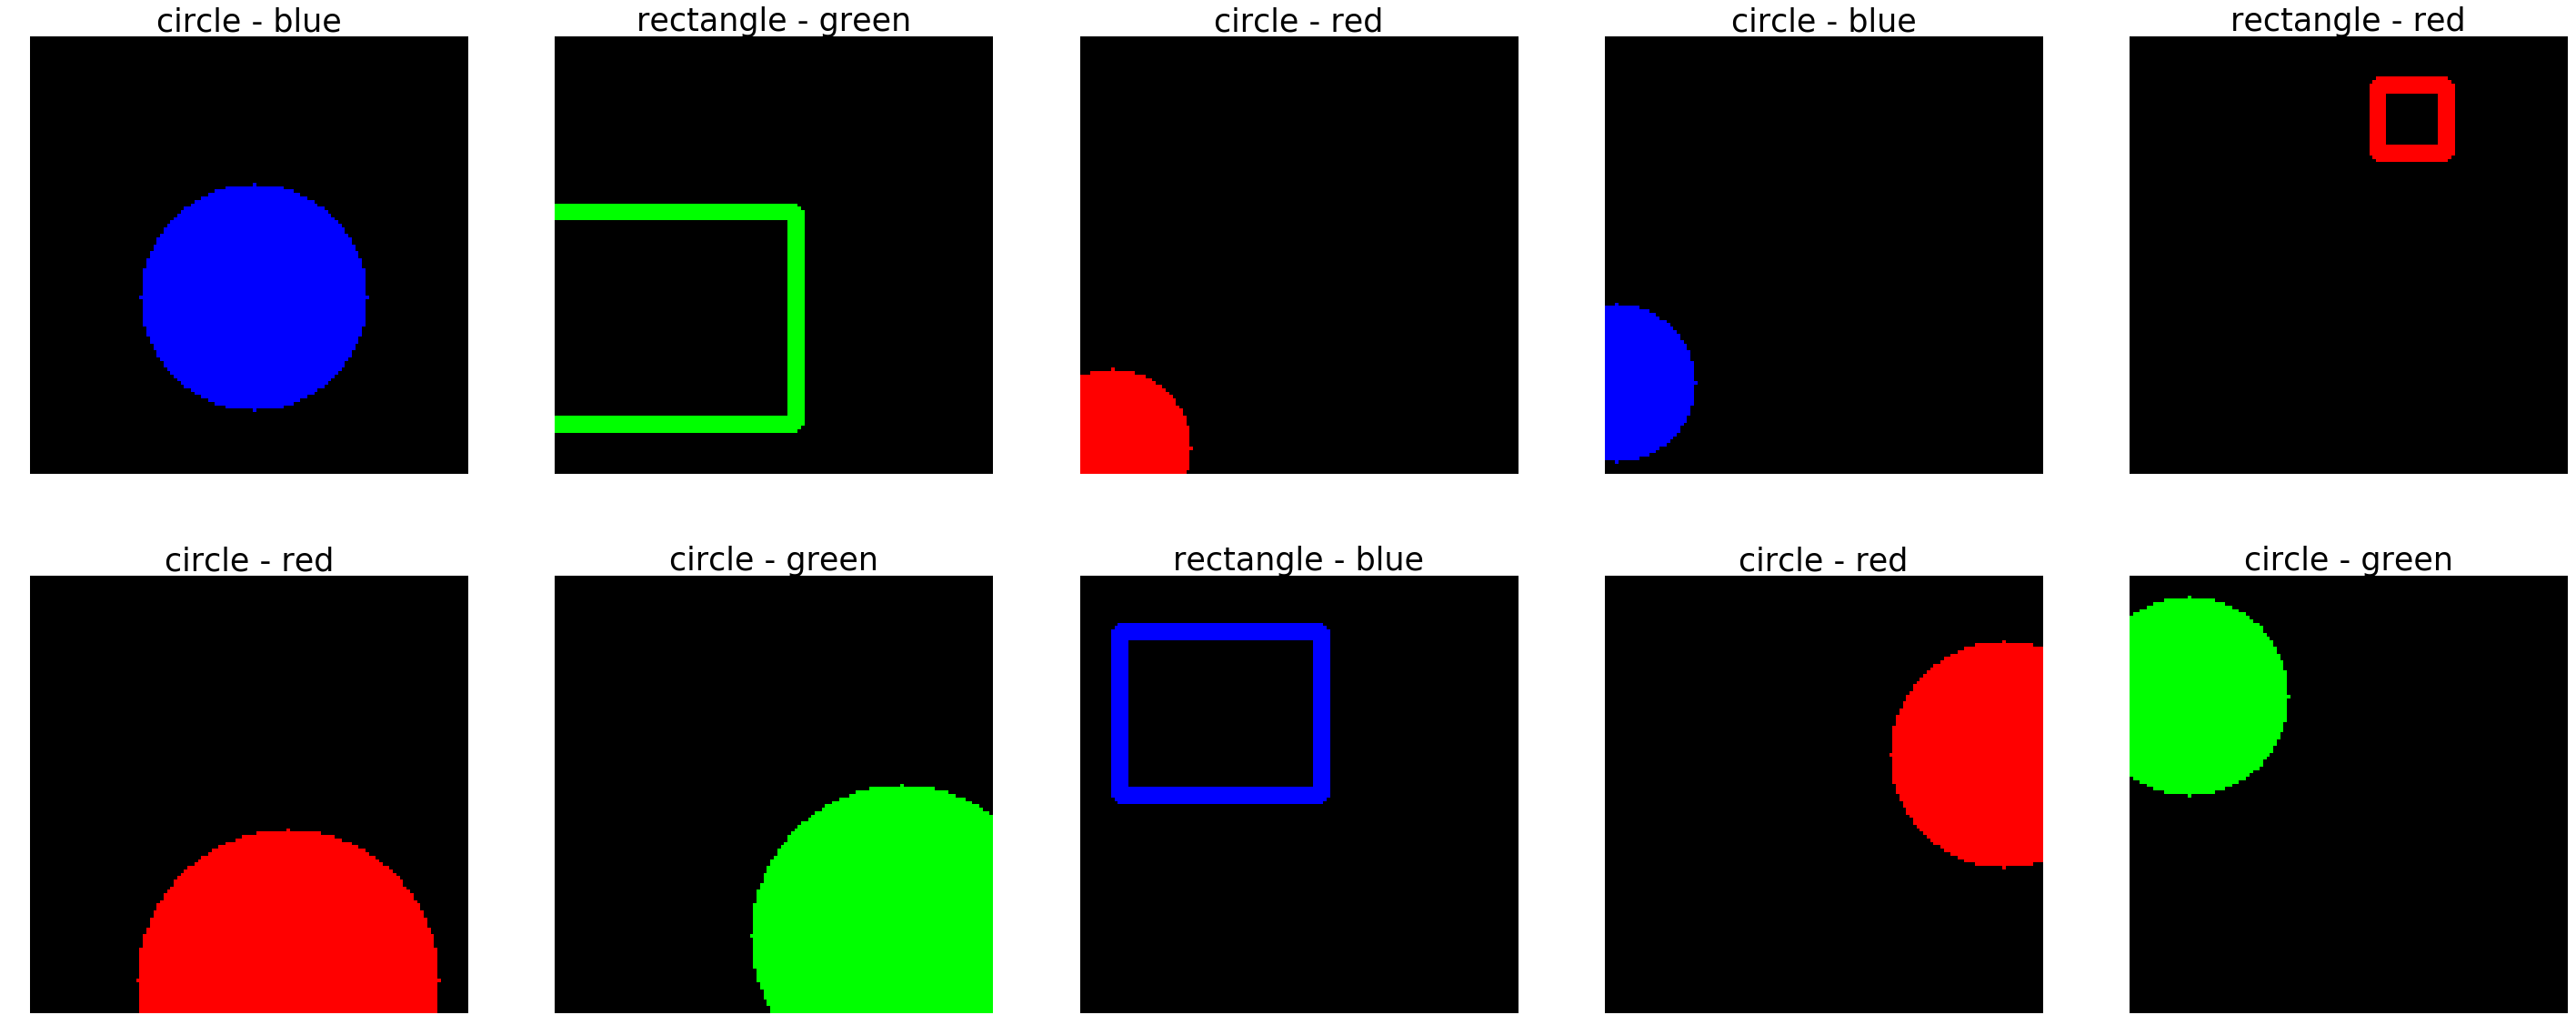

In [11]:
new_data, _, _ =  create_data(60)
display_random_data(model,new_data, 5)